In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display as ipython_display

import sys
import os
import pickle
import astropy.units as u
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"
dir_TNGcube = dir_repo+"/TNGcube"


sys.path.append(dir_BinnedFit)
from binnedFit_utilities import lambda_to_velocity, velocity_to_lambda, load_pickle
from gamma import GammaInference
from chainTool import ChainTool

sys.path.append(dir_TNGcube)
from TNGcube import TNGmock, ParametersTNG

Populating the interactive namespace from numpy and matplotlib


In [2]:
subhalo = pickle.load(open('../notebooks/subhalo_35.pkl', 'rb'))

In [3]:
pars = {}
pars['spinR'] = [0, 0, -1]
pars['sini'] = 1.
pars['theta_int'] = 0. #np.pi/6.
pars['g1'] = 0.
pars['g2'] = 0.
pars['redshift'] = 0.3
pars['psfFWHM'] = 0.5
pars['sigma_thermal'] = 16.  # [unit: km/s]

pars['slitAngles'] = [0., np.pi/2]

lambda_cen0 = ParametersTNG.lineLambda0['Halpha']
#lambda_cen0 = (lineLambda0['OIIa']+lineLambda0['OIIb'])/2.

pars['lambda_cen'] = (1+pars['redshift'])*lambda_cen0

pars['expTime'] = 30.*60.              # [unit: sec]
pars['area'] = 3.14 * (1000./2.)**2    # telescope area [unit: cm2]

pars['ref_SDSS_lineL'] = 3.*1e-17      # [unit: erg/s/Angstrom/cm2]    # * u.erg/u.second/u.Angstrom/u.cm**2

fiber_SDSS = np.pi * 1.5**2.           # fiber size [unit: arcsec2]
refSDSSspec = pars['ref_SDSS_lineL'] * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print('reference SDSS fiber spec:', refSDSSspec)

pars['lineflux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]
pars['lineflux']

pars['ngrid'] = 256

reference SDSS fiber spec: 2.9999999999999994e-16 erg / (cm2 nm s)


In [4]:
par_meta = {}

par_meta['theta'] = 0. *np.pi/180.
par_meta['dx'] = [0.,0.,0.]
par_meta['dv'] = [0.0,0.,0.]

In [5]:
mock = TNGmock(pars=pars, subhalo=subhalo, par_meta=par_meta)

In [6]:
dataInfo = mock.gen_mock_data(noise_mode=0)

In [7]:
dataInfo['par_fid']

{'redshift': 0.3,
 'sini': 1.0,
 'theta_int': 0.0,
 'aspect': 0.2,
 'spinR': [0, 0, -1],
 'g1': 0.0,
 'g2': 0.0,
 'ngrid': 256,
 'image_size': 128,
 'pixScale': 0.1185,
 'nm_per_pixel': 0.033,
 'lambda_cen': 853.3993,
 'sigma_thermal': 16.0,
 'psfFWHM': 0.5,
 'psf_g1': 0.0,
 'psf_g2': 0.0,
 'Resolution': 5000.0,
 'slitWidth': 0.06,
 'expTime': 1800.0,
 'area': 785000.0,
 'throughput': 0.29,
 'ref_SDSS_peakI': 3e-17,
 'read_noise': 3.0,
 'slitAngles': [0.0, 1.5707963267948966],
 'ref_SDSS_lineL': 3e-17,
 'lineflux': 4.244131815783875e-17,
 'vcirc': 121.588,
 'r_hl_image': 0.5,
 'vscale': 0.5,
 'r_0': 0.0,
 'v_0': 0.0,
 'flux': 284.85464,
 'subGridPixScale': 0.05924999999999958}

# 0. View mock data 

/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../TNGcube/TNGcube.py:708: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fda0a9ffad0>)

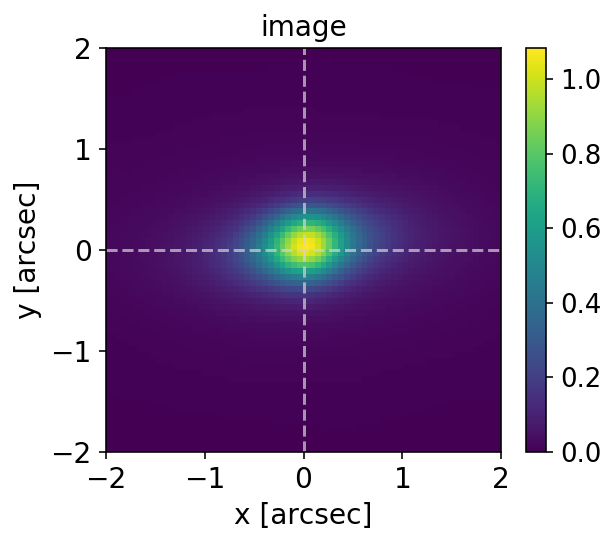

In [8]:
dataInfo['image'].display(xlim=[-2., 2.])

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


time cost in gaussFit_spec2D: 0.39200806617736816 (secs)


/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../BinnedFit/spec2D.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fda0ac72e50>)

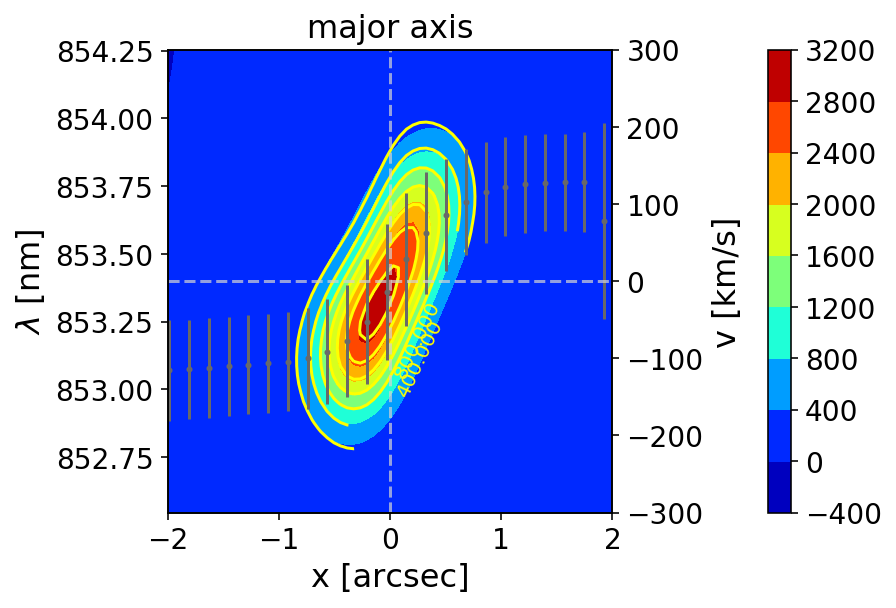

In [9]:
model_major = dataInfo['spec'][0].GF.model
dataInfo['spec'][0].display(xlim=[-2., 2], vlim=[-300, 300], mark_fit=True, model=model_major, title='major axis')

time cost in gaussFit_spec2D: 0.4054279327392578 (secs)


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd9ca51ee90>)

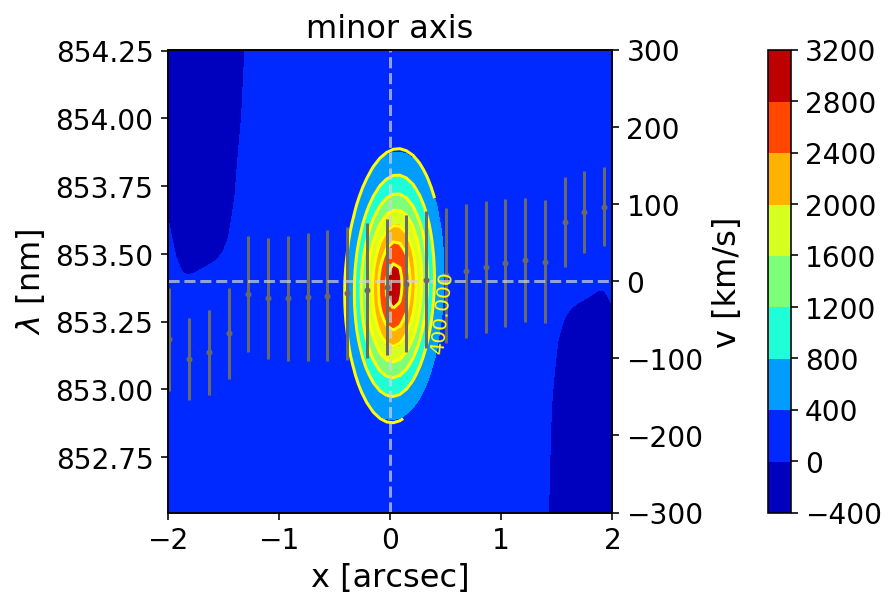

In [10]:
model_minor = dataInfo['spec'][1].GF.model
dataInfo['spec'][1].display(xlim=[-2., 2], vlim=[-300, 300], mark_fit=True, model=model_minor, title='minor axis')

# load ChainInfo

In [11]:
dir_file = '/Users/hhg/Research/kinematic_lensing/data/mock_TNG/'
chainfile = dir_file +'chainTNG_Ha_noise0_g10.00_g20.00_sini1.0_z0.30_thetaINT0.0_256_300k_D0421.pkl'
chainInfo = load_pickle(chainfile)
print(chainInfo['chain'].shape)

pars = chainInfo['par_fid']

(100, 3000, 10)


In [12]:
Chain = ChainTool(chainInfo, Nburn=100*1500, Nend=100*3000)
Chain.add_vsini()

In [13]:
from chainconsumer import ChainConsumer
blue        = "#214F94"
red         = "#CC0204"
yellow      = "#FFA903"
gray        = "#858278"
black       = "#000000"
green       = "#73ab24"
purple      = "#8600C8"
lightblue   = "#6898FF"
lightblue2  = "#82b9e6"
yellowgreen = "#8dcd32" #"#8DE900"
lightteal   = "#7FC2BF"
teal        = "#51ABAE"
lightgray   = "#CDCDCD"

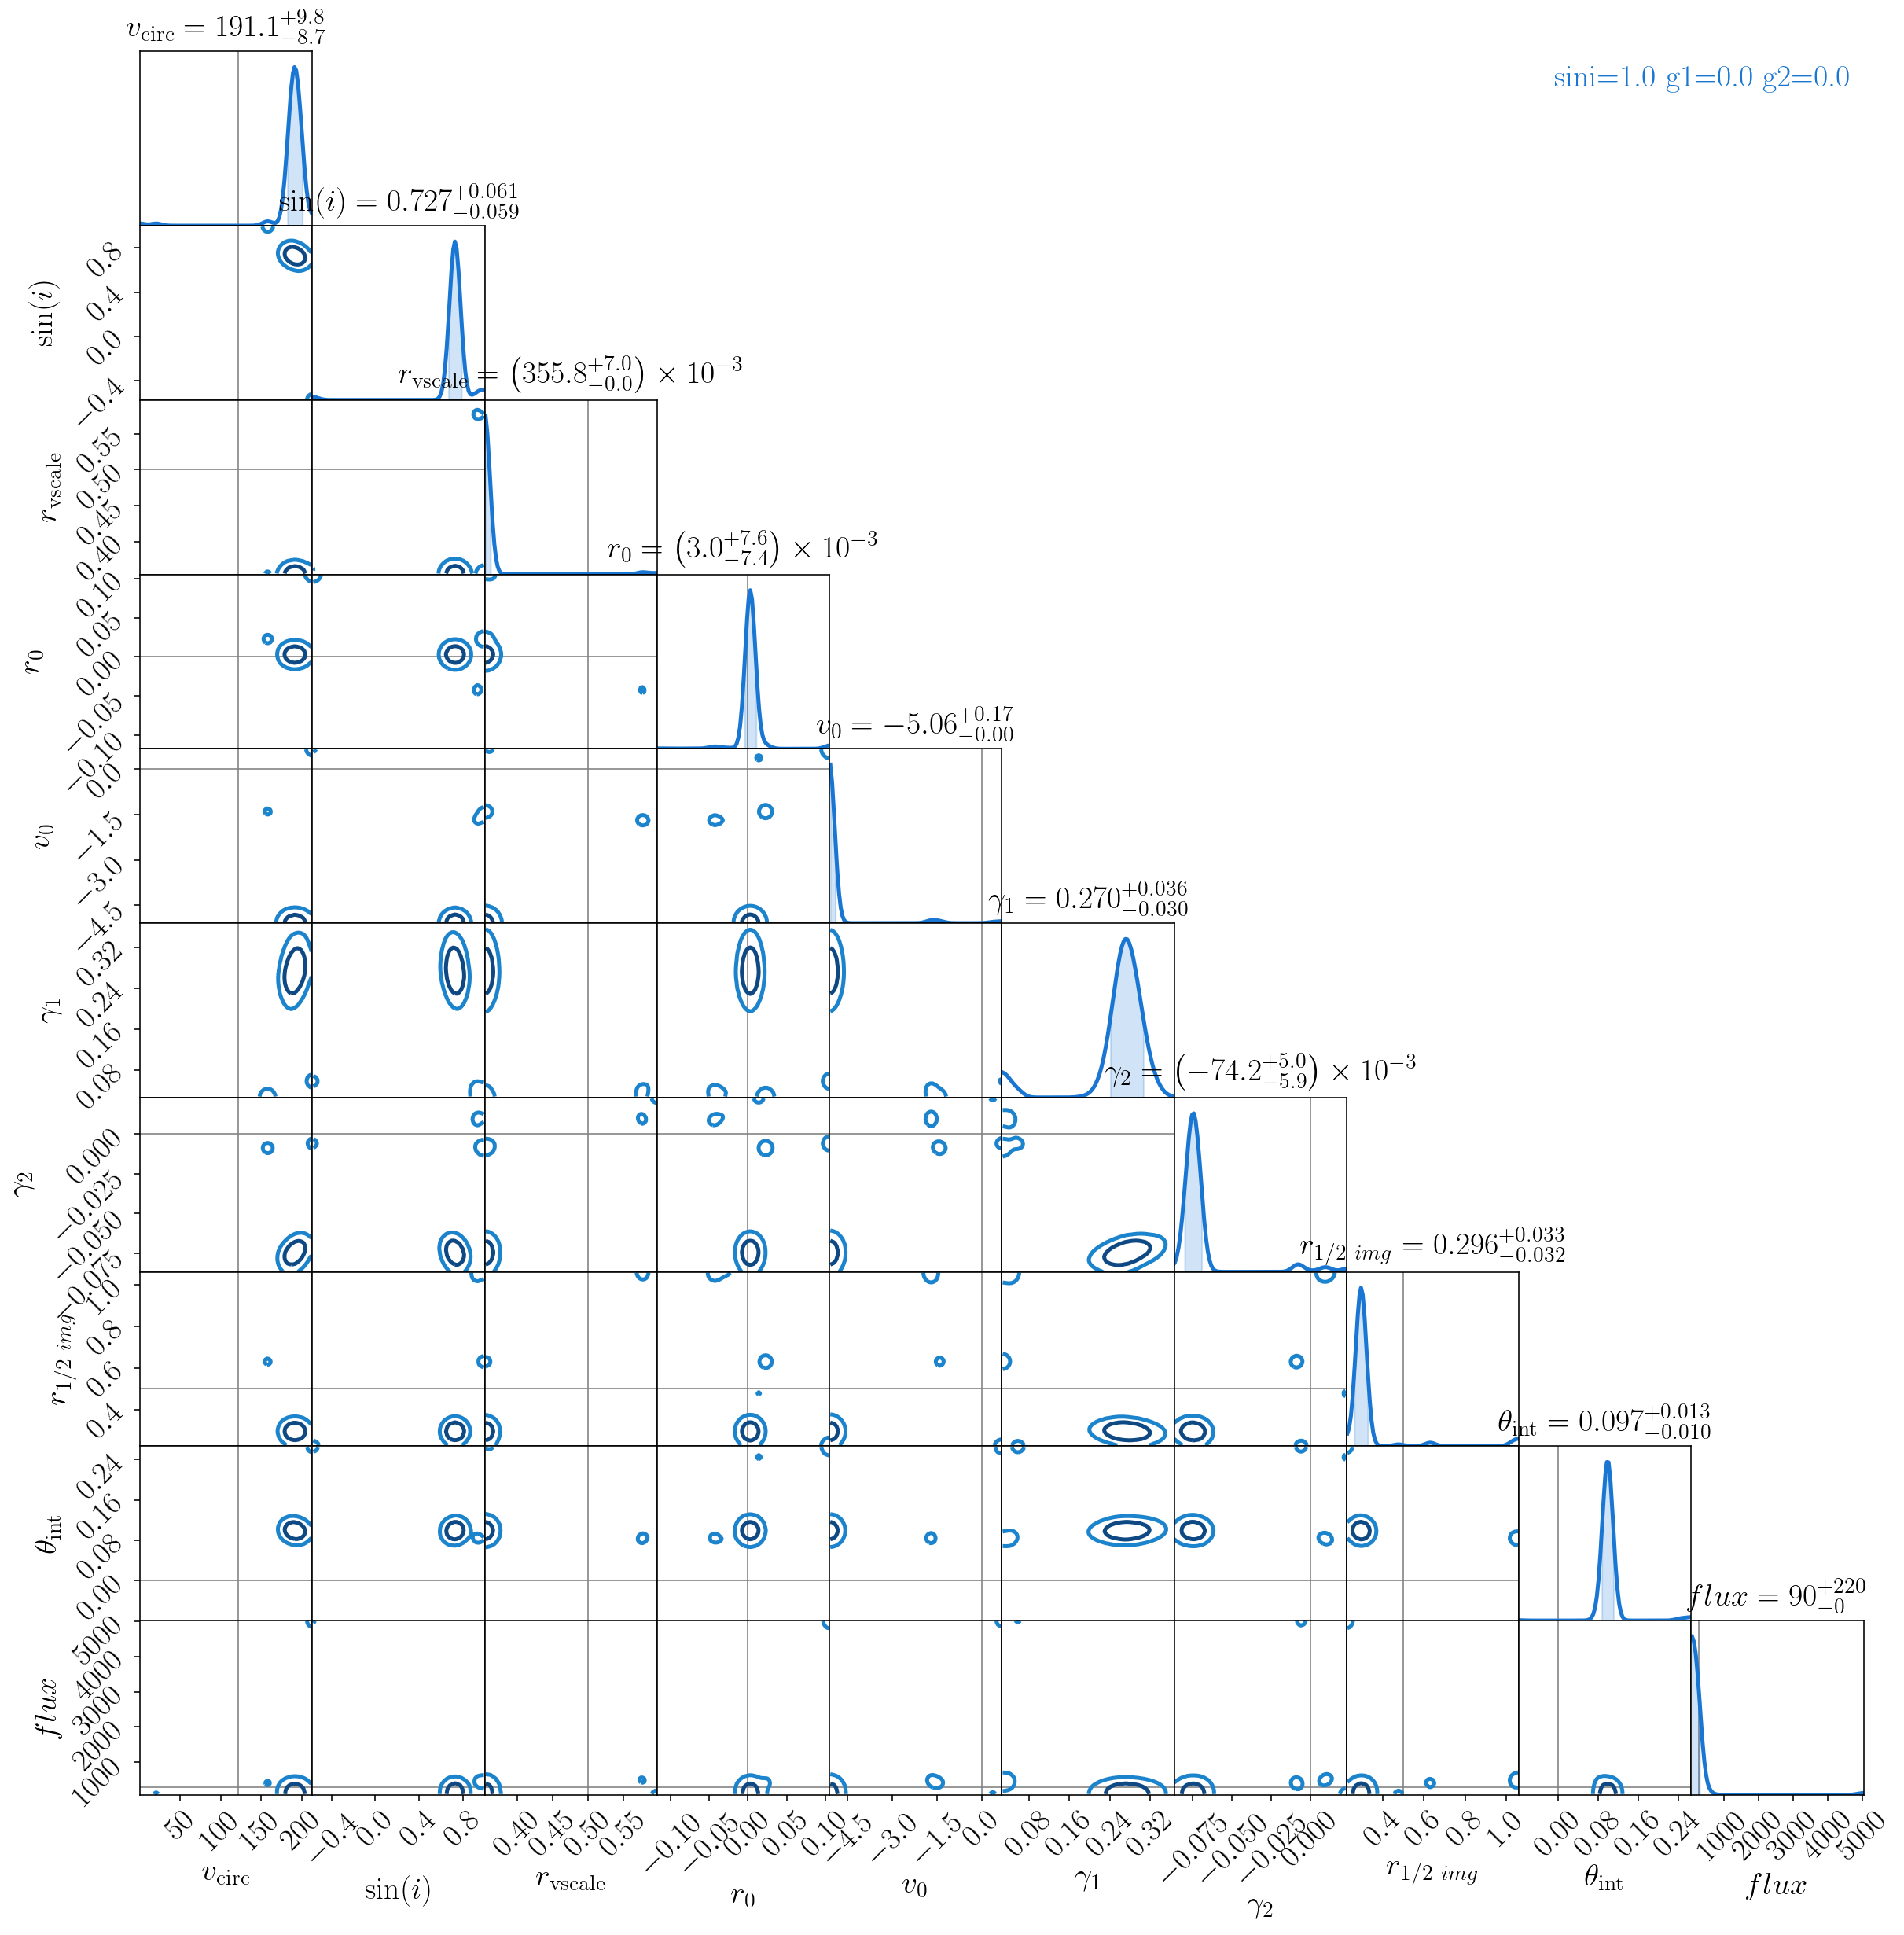

In [14]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = chainInfo['par_key']

#legend_chain = "sini=%.1f"%pars['sini']
g1=pars['g1']
g2=pars['g2']
sini=pars['sini']
legend_chain = f"sini={sini} g1={g1} g2={g2}"

parID1, parName1, par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1], parameters=parName1, name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20,
            shade=[False]*Nchains,
            statistics=statistics,summary=True)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("_fig_chain.pdf", transparent=True)

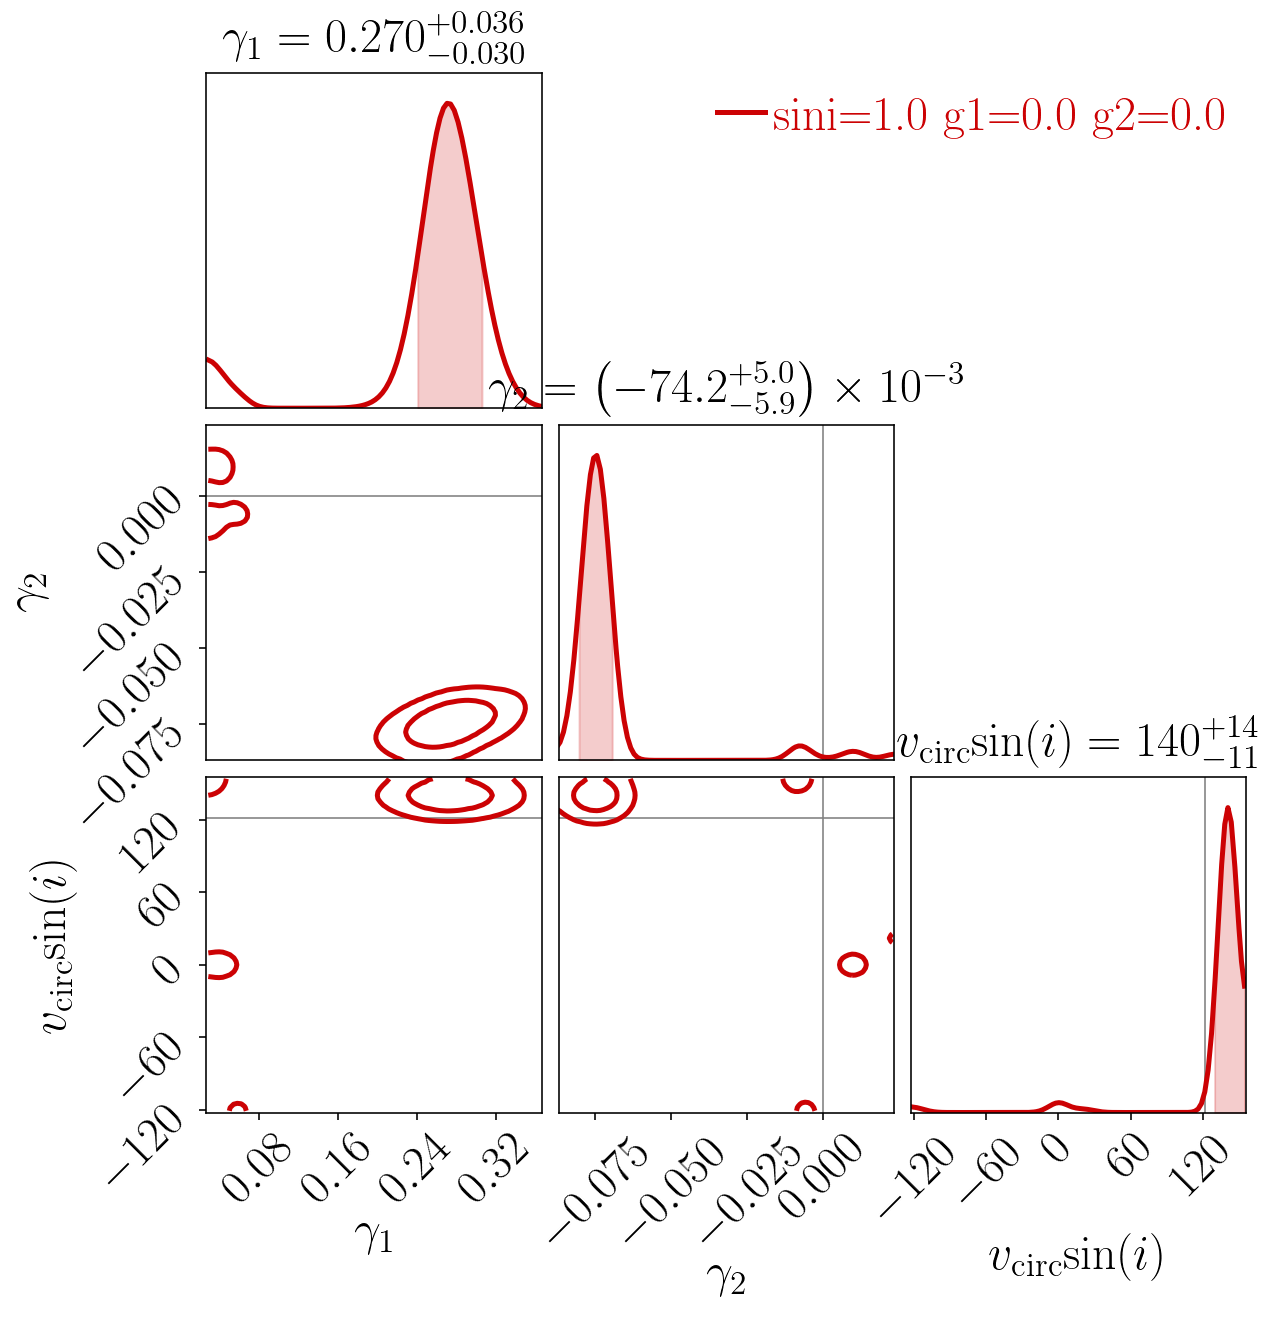

In [15]:
Nchains = 1
colors = [red, blue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['g1','g2', 'vsini'] #, 'v_0'

legend_chain = f"sini={pars['sini']} g1={pars['g1']} g2={pars['g2']}"


parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]    , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=24,tick_font_size=24,
            shade=[False]*Nchains,
            colors=colors,
            linestyles=lines,
            statistics=statistics,
            shade_gradient=[0]*Nchains,
            summary=True) #,color_params='posterior'

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.14, right=0.9, bottom=0.14, top=0.9)

fig.set_size_inches(5.0 + fig.get_size_inches())
fig.savefig("_figchain.pdf", transparent=True)

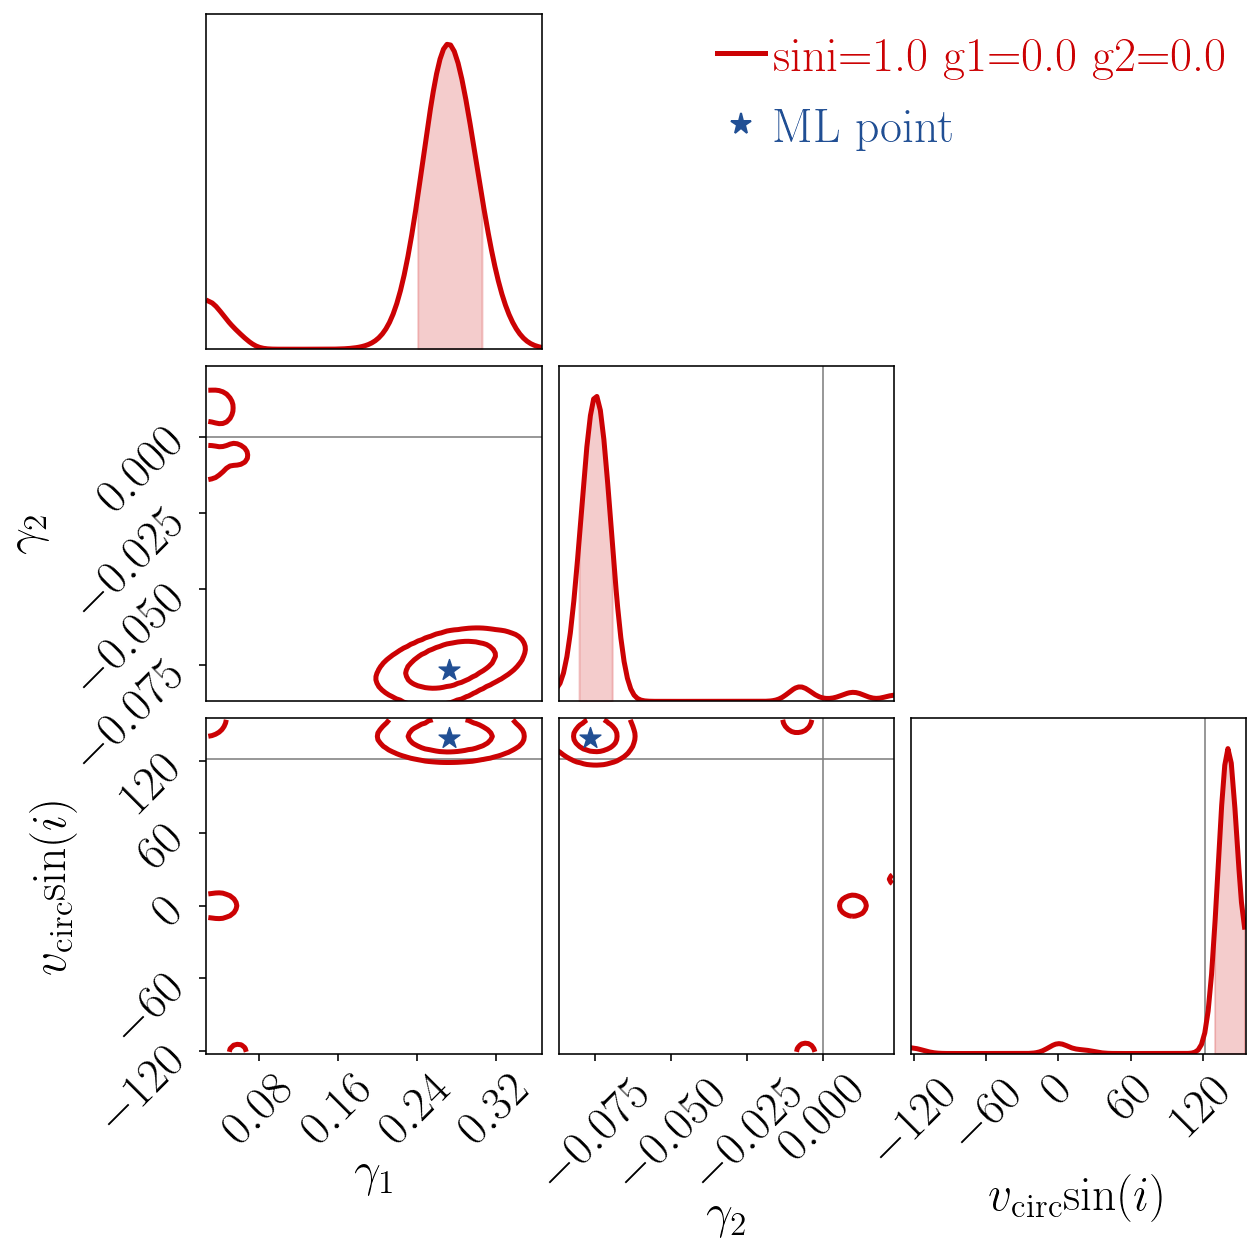

In [16]:
Nchains = 2
colors = [red, blue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['g1','g2', 'vsini'] #, 'v_0'

legend_chain = f"sini={pars['sini']} g1={pars['g1']} g2={pars['g2']}"


parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]    , parameters=parName1 ,name=legend_chain)

MLmain, MLmain0 = Chain.par_maxlike()
c.add_marker(MLmain[parID1], parameters=parName1, marker_style='*', marker_size=120, name='ML point')

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=24,tick_font_size=24,
            shade=[False]*Nchains,
            colors=colors,
            linestyles=lines,
            statistics=statistics,
            shade_gradient=[0]*Nchains,
            summary=True) #,color_params='posterior'

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.14, right=0.9, bottom=0.14, top=0.9)

fig.set_size_inches(5.0 + fig.get_size_inches())
fig.savefig("_figchain1.pdf", transparent=True)

# ML point

In [17]:
MLmain, MLmain0 = Chain.par_maxlike()

print('maximum logLike: ', MLmain0)

for ind, key in enumerate(chainInfo['par_key']):
    print(f'{key} : {MLmain[ind]:.2f}')

maximum logLike:  -320849.0763032828
vcirc : 185.24
sini : 0.75
vscale : 0.36
r_0 : 0.00
v_0 : -5.06
g1 : 0.27
g2 : -0.08
r_hl_image : 0.30
theta_int : 0.10
flux : 207.20


# check fit status at par_in

In [18]:
GI = GammaInference(dataInfo, 
                    active_par_key=['vcirc', 'sini', 'vscale', 'r_0', 'v_0', 'g1', 'g2',  'r_hl_image', 'theta_int', 'flux'], 
                    par_fix=None, vTFR_mean=120.)

In [19]:
active_par_fid = [GI.par_fid[key] for key in GI.active_par_key]

print('par fid')
for ind, key in enumerate(GI.active_par_key):
    print(f'  {key} : {active_par_fid[ind]:.2f}')

par fid
  vcirc : 121.59
  sini : 1.00
  vscale : 0.50
  r_0 : 0.00
  v_0 : 0.00
  g1 : 0.00
  g2 : 0.00
  r_hl_image : 0.50
  theta_int : 0.00
  flux : 284.85


In [20]:
active_par_in = MLmain
#active_par_in = active_par_fid

par_in = GI.Pars.gen_par_dict(active_par=active_par_in, active_par_key=GI.active_par_key, par_ref=GI.par_base)

print('par ML')
for ind, key in enumerate(GI.active_par_key):
    print(f'  {key} : {active_par_in[ind]:.2f}')

par ML
  vcirc : 185.24
  sini : 0.75
  vscale : 0.36
  r_0 : 0.00
  v_0 : -5.06
  g1 : 0.27
  g2 : -0.08
  r_hl_image : 0.30
  theta_int : 0.10
  flux : 207.20


In [21]:
logPrior_vcirc = GI.Pars.logPrior_vcirc(vcirc=par_in['vcirc'], sigma_TF_intr=GI.sigma_TF_intr, vTFR_mean=GI.vTFR_mean)
logL_image, model_img = GI._cal_loglike_image(par_in)
logL_spec0, model_spec0 = GI._cal_loglike_spec(par_in, IDspec=0)
logL_spec1, model_spec1 = GI._cal_loglike_spec(par_in, IDspec=1)

totL = GI.cal_loglike(active_par_in)
print(f'tot logLike: {totL:.2f}')
print(f'  logPrior: {logPrior_vcirc:.2f}')
print(f'  logL_image: {logL_image:.2f}')
print(f'  logL_spec0: {logL_spec0:.2f}')
print(f'  logL_spec1: {logL_spec1:.2f}')

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


tot logLike: -320849.19
  logPrior: -2.78
  logL_image: -177.73
  logL_spec0: -260621.01
  logL_spec1: -60047.67


In [22]:
# image SNR
np.sqrt(np.sum(dataInfo['image'].array**2/dataInfo['image'].array_var**2))

1029.3135

In [23]:
np.sum(dataInfo['image'].array)/len(dataInfo['image'].array)

1.1127134561538696

In [24]:
# spec major SNR
np.sqrt(np.sum(dataInfo['spec'][0].array**2/dataInfo['spec'][0].array_var**2))

12297.289561207808

In [25]:
# spec minor SNR
np.sqrt(np.sum(dataInfo['spec'][1].array**2/dataInfo['spec'][1].array_var**2))

9020.136917285377

## display fit at par_in

/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../TNGcube/TNGcube.py:708: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


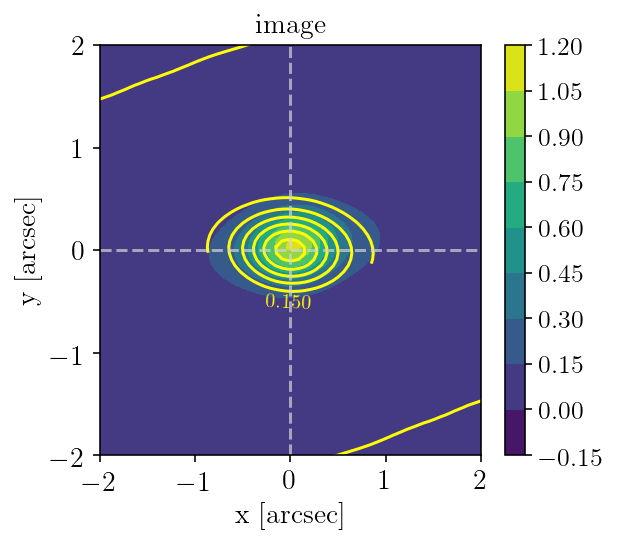

In [26]:
fig0, ax0 = dataInfo['image'].display(xlim=[-2.,2.], model=model_img)

/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../BinnedFit/spec2D.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


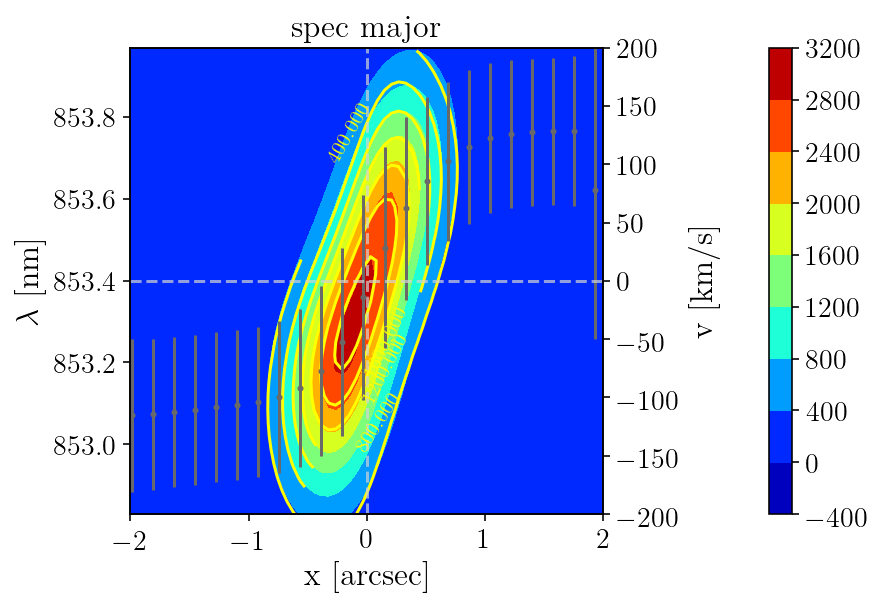

In [27]:
fig1, ax1 = dataInfo['spec'][0].display(xlim=[-2.,2.], vlim=[-200., 200,], model=model_spec0, mark_fit=True, title='spec major')

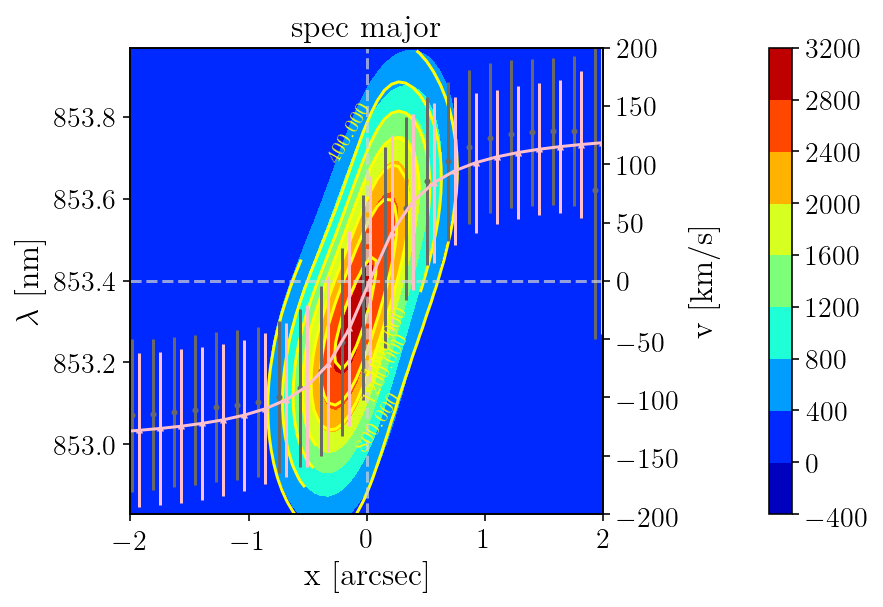

In [28]:
cenLambda, amp, sigma = GI._cal_bestfit_specStats(par_in, IDspec=0)
spaceGrid = GI.RFs[0].spec2D.spaceGrid
ax1.errorbar(spaceGrid[2::3], cenLambda[2::3], sigma[2::3], color='pink', marker='^', markersize=2, ls='-')
ipython_display(fig1)

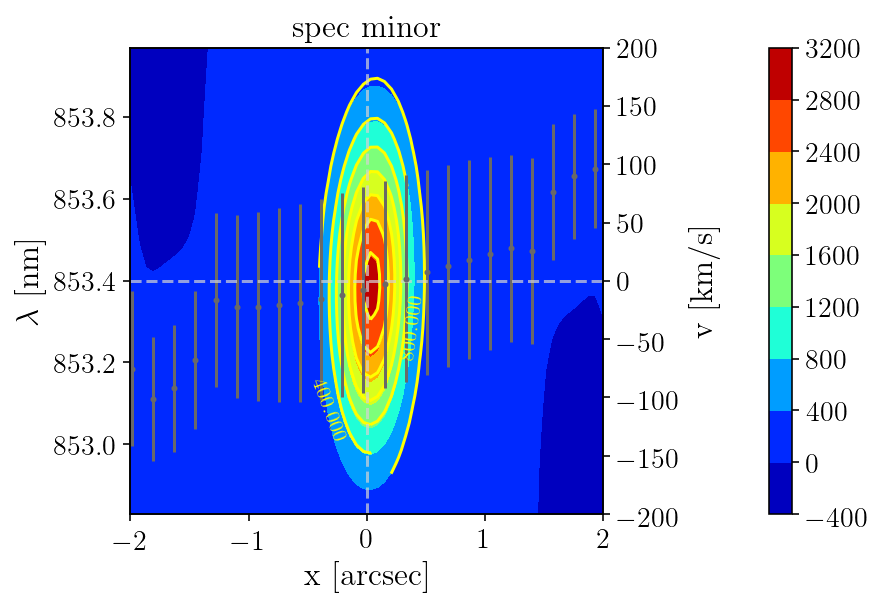

In [29]:
fig2, ax2 = dataInfo['spec'][1].display(xlim=[-2.,2.], vlim=[-200., 200,], model=model_spec1, mark_fit=True, title='spec minor')

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


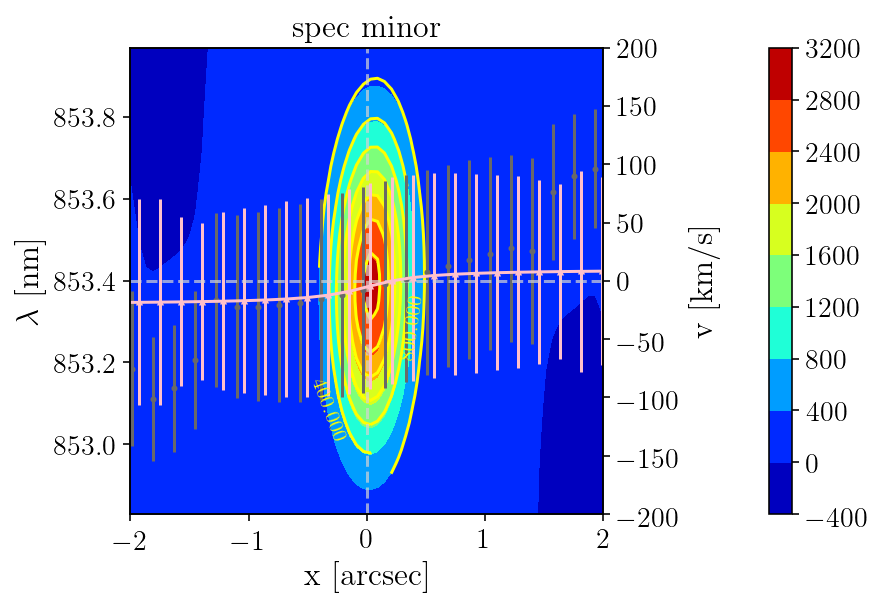

In [30]:
cenLambda, amp, sigma = GI._cal_bestfit_specStats(par_in, IDspec=1)
spaceGrid = GI.RFs[1].spec2D.spaceGrid
ax2.errorbar(spaceGrid[2::3], cenLambda[2::3], sigma[2::3], color='pink', marker='^', markersize=2, ls='-')
ipython_display(fig2)

#  ------ End ------

In [31]:
chainInfo = GI.run_MCMC(Nwalker=30, Nsteps=2, outfile_MCMC='chain.pkl', save_step_size=2)

  0%|          | 0/2 [00:00<?, ?it/s]/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2/2 [00:04<00:00,  2.08s/it]

steps_taken 2
Total MCMC time (mins): 0.1012214461962382
